In [1]:
## ALL DEPENDENCIES ARE LISTED IN THIS CELL ##
## Code by Cailum M. K. Stienstra
## February 22, 2023

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor, RidgeCV, Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from mlxtend.regressor import StackingRegressor

from csv import writer

from rdkit.Chem import Descriptors
from rdkit import Chem
import rdkit



c:\Users\cmkst\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## **********************FEATURE ENGINEERING**********************
data = pd.read_csv(r'C:\Users\cmkst\Desktop\Grad School\ML DMS Paper\SI_Data\MLData_TraininglogP.csv', encoding='latin1') 
## Use file from SI to train - specify correc

def get_total_bond_order(smi): ## function to calculate total bond order as defined in Lovric et al. 
    mol = Chem.MolFromSmiles(smi)
    total_order = 0
    for bond in mol.GetBonds():
        total_order += bond.GetBondTypeAsDouble()
    return total_order

def carbon_anal(smi): ## Generate summary statistics for a molecule -> takes a SMILES string as input and returns different structural descriptions (see below)
    mol = Chem.MolFromSmiles(smi)
    total = 0
    c_count = 0
    c_ar = 0
    c_SP2 = 0
    f_count = 0
    cl_count = 0
    oh_count = 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 6:
            c_count +=1
            if atom.GetIsAromatic():
                c_ar +=1 
            if atom.GetHybridization() == rdkit.Chem.rdchem.HybridizationType.SP2:
                c_SP2 += 1
        if atom.GetAtomicNum() == 9:
            f_count +=1
        if atom.GetAtomicNum() == 17:
            cl_count +=1
        if atom.GetAtomicNum() == 8:
            if atom.GetTotalNumHs() == 1:
                oh_count+=1
        total+=1

    frac_C = c_count / total
    return c_ar, frac_C, f_count, oh_count, cl_count


def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count


#Un-normalized data
inputs = data.drop(labels=['Compound',  'LogP_pred', 'LogP_predRange'], axis = 'columns')


inputs['r_bonds'] =np.transpose(np.zeros(data.shape[0])) ## Number of Rotatable Bonds 
inputs['a_prop'] =np.transpose(np.zeros(data.shape[0])) ## Aromatic Proportion = #C_Ar / #Heavy atoms
#inputs['t_order'] =np.transpose(np.zeros(data.shape[0])) ## Total bond order
# inputs['mr'] =np.transpose(np.zeros(data.shape[0])) 
inputs['c_ar'] =np.transpose(np.zeros(data.shape[0]))  # Number of Aromatic Carbons
inputs['c_frac'] =np.transpose(np.zeros(data.shape[0])) # Fraction of Aromatic Carbons
inputs['TPSA'] =np.transpose(np.zeros(data.shape[0]))  # Topological Polar Surface Area including contributions from P, O
inputs['f'] =np.transpose(np.zeros(data.shape[0])) # Number of Fluorine 
inputs['oh'] =np.transpose(np.zeros(data.shape[0])) # Number of R-OH groups
inputs['HBD'] =np.transpose(np.zeros(data.shape[0])) # Number of hydrogen bond donors
inputs['HBA'] =np.transpose(np.zeros(data.shape[0])) # Number of hydrogen bond acceptors
inputs['Cl'] = np.transpose(np.zeros(data.shape[0])) # Number of Chlorine

r_bondsL =np.zeros(data.shape[0]) 
a_propL =np.zeros(data.shape[0])  
# inputs['t_order'] =np.transpose(np.zeros(data.shape[0])) 
# inputs['mr'] =np.transpose(np.zeros(data.shape[0])) 
c_arL =np.zeros(data.shape[0])  
c_fracL= np.zeros(data.shape[0]) 
TPSAL =np.zeros(data.shape[0]) 
FL =np.zeros(data.shape[0]) 
HBDL =np.zeros(data.shape[0]) 
HBAL =np.zeros(data.shape[0])
OhL = np.zeros(data.shape[0])
minPAL = np.zeros(data.shape[0])
ClL= np.zeros(data.shape[0])

for i in range(len(inputs)):
    smi = inputs['SMILES'][i]
    c_ar, frac_C,f_count, oh_count, cl_count = carbon_anal(smi)

    mol = Chem.MolFromSmiles(smi)
    aa = AromaticAtoms(mol)
    ha = Descriptors.HeavyAtomCount(mol)
    Aromatic_prop = aa/ha
#     inputs['r_bonds'][i] =Descriptors.NumRotatableBonds(mol)
    #inputs['t_order'][i] =get_total_bond_order(smi)

    a_propL[i] = Aromatic_prop
    r_bondsL[i] =Descriptors.NumRotatableBonds(mol)

    c_arL[i] =c_ar
    c_fracL[i] =frac_C
    TPSAL[i] =Descriptors.TPSA(mol,includeSandP=True)
    FL[i] = f_count
    HBDL[i] = Chem.rdMolDescriptors.CalcNumHBD(mol)
    HBAL[i] = Chem.rdMolDescriptors.CalcNumHBD(mol)
    minPAL[i] = Chem.Descriptors.MinPartialCharge(mol)
    OhL[i] = oh_count
    ClL[i] = cl_count
    
inputs['r_bonds'] =np.transpose(r_bondsL) 
inputs['a_prop'] =np.transpose(a_propL) 
# inputs['t_order'] =np.transpose(t_orderL) 
# inputs['mr'] =np.transpose(np.zeros(data.shape[0])) 
inputs['c_ar'] =np.transpose(c_arL) 
inputs['c_frac'] =np.transpose(c_fracL) 
inputs['TPSA'] =np.transpose(TPSAL) 
# inputs['LogP'] =np.transpose(np.zeros(data.shape[0])) 
inputs['f'] =np.transpose(FL)
inputs['cl'] =np.transpose(ClL)
inputs['HBD'] =np.transpose(HBDL)
inputs['HBA'] =np.transpose(HBAL)
inputs['minPA'] =np.transpose(minPAL)
inputs['oh'] = np.transpose(OhL)
inputs['Cl'] = np.transpose(ClL)
## Comment out these lines to reduce to the pure experimental model


    
inputs =inputs.drop(labels=['SMILES'], axis = 'columns')


## ****************Uncomment this line to reduce to the purely structural description
# inputs =inputs.drop(labels=['b3_N2','b5_N2','b7_N2', 'b3_MeOH','b5_MeOH','b7_MeOH','BW_CCS','mz',
# 'N2SV1500','N2SV2000', 'N2SV2500','N2SV3000','N2SV3250', 'N2SV3500','N2SV3750', 'N2SV4000',
# 'MeOHSV1500','MeOHSV1500','MeOHSV2000','MeOHSV2500', 'MeOHSV3000','MeOHSV3250', 'MeOHSV3500', 'MeOHSV3750','MeOHSVSV4000'], axis = 'columns')

print(inputs.head())

target = data['LogP_pred']



       mz  BW_CCS  N2SV1500  N2SV2000  N2SV2500  N2SV3000  N2SV3250  N2SV3500  \
0  337.12  178.78      2.69      3.70      3.79      4.71      5.87      6.53   
1  229.11  142.99      2.46      3.47      3.55      4.64      5.98      6.77   
2  178.10  135.22      0.70      1.10      2.10      3.80      4.61      6.00   
3   76.00  116.62     -0.32     -3.08     -7.78    -13.64    -16.65    -19.66   
4  376.02  173.60      1.76      2.35      2.36      3.03      3.86      4.25   

   N2SV3750  N2SV4000  ...  c_ar    c_frac   TPSA    f   oh  HBD  HBA   Cl  \
0      7.19      8.76  ...  14.0  0.791667  54.50  0.0  0.0  0.0  0.0  1.0   
1      7.57      9.51  ...   2.0  0.600000  86.36  0.0  0.0  1.0  1.0  0.0   
2      8.79     13.80  ...   6.0  0.769231  38.33  0.0  0.0  1.0  1.0  0.0   
3    -22.66    -25.65  ...   0.0  0.400000  63.32  0.0  1.0  2.0  2.0  0.0   
4      4.65      5.79  ...  16.0  0.640000  65.60  1.0  0.0  0.0  0.0  2.0   

    cl     minPA  
0  1.0 -0.251022  
1  0.0

(50, 38)
(100, 38)
(150, 38)
(200, 38)
(250, 38)


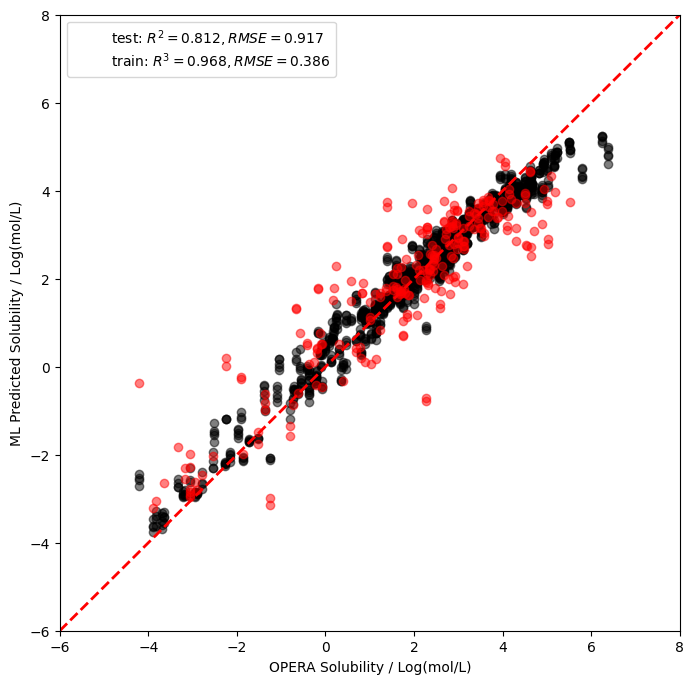

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


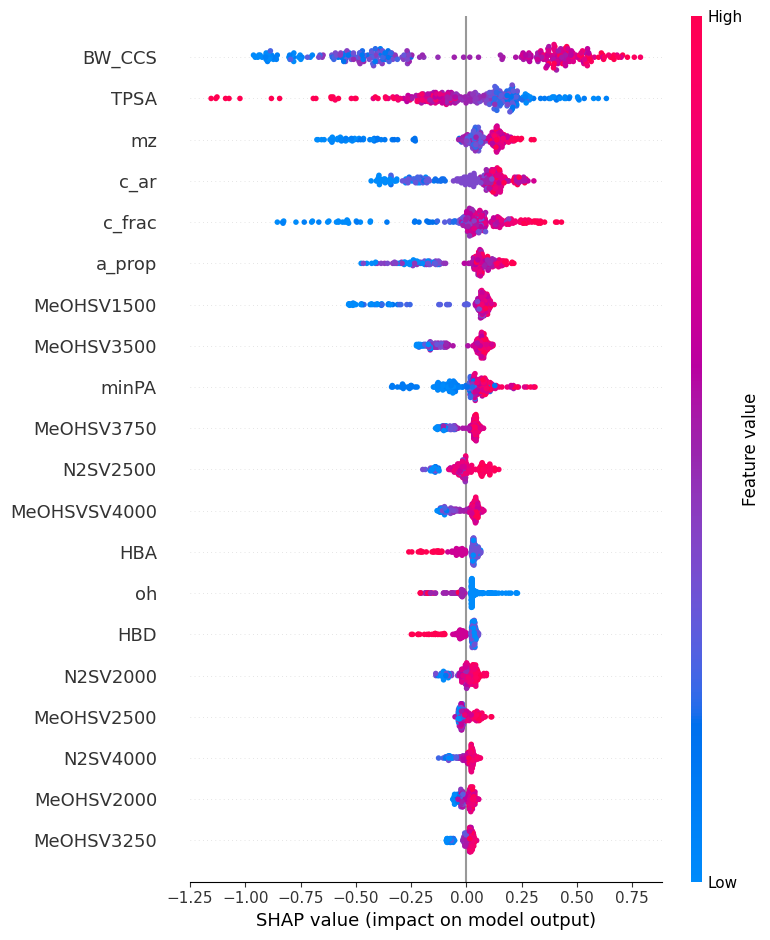

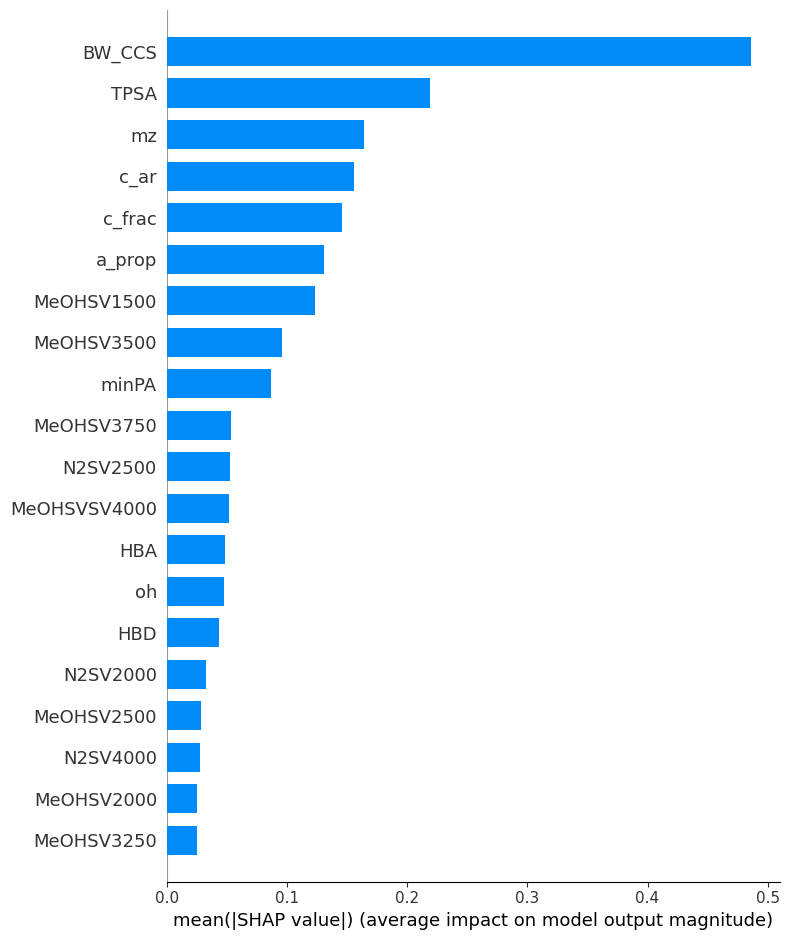

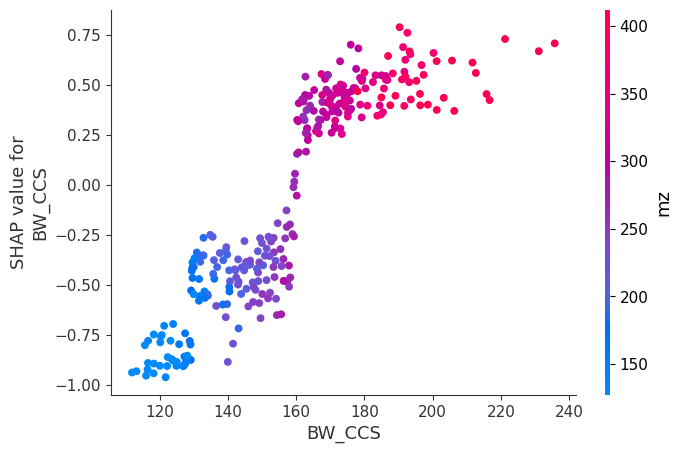

In [3]:
## **********************Model Constuction and Training**********************

## Constructing regresssors
rf = RandomForestRegressor(random_state=26, n_estimators=1154, min_samples_split=3, min_samples_leaf=2, criterion='squared_error', bootstrap=True)

gbdt = GradientBoostingRegressor(n_estimators = 707,  subsample = 0.55, loss = "squared_error", \
criterion = "friedman_mse", learning_rate = 0.019, alpha = 0.9)

svr= SVR(kernel='rbf', C=4, epsilon=0.9)

lasso = Lasso(alpha=0.5,  fit_intercept=False, max_iter=10000, random_state=42, tol=0.0001)

## Stack for ensemble stack
stack = regressors=[rf,gbdt, svr]

stregr = StackingRegressor(regressors=stack, 
                           meta_regressor=lasso)

clf = rf ## This line specifies which regressor you are using in trainingof those define d



## Building lists for error accumulation
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
a = []
b = []
c = []
d = []
ts = 0.85 ## size of the training set - currently set to 85%
first = True
sub_error = []
sub_errort = []


for i in range(60,65): ## The random seeds to test - currently testing 5 seeds 

    x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size = 1-ts, random_state = i) ## splitting datta

    clf.fit(x_train, y_train) # Training model
    y_predict_rfr = clf.predict((x_test)) # generating predictions for test set
    y_train_pred =clf.predict((x_train)) # generating predictions fro training set

    ##Binning errors
    a = a + list(y_train)
    b = b + list(y_train_pred)
    c = c + list(y_test)
    d = d + list(y_predict_rfr)


    arr_1 = np.transpose(np.vstack([np.transpose(x_train),np.array(y_train), np.array(y_train_pred)]))
    arr_2 = np.transpose(np.vstack([np.transpose(x_test),np.array(y_test), np.array(y_predict_rfr)]))
    arr =  arr_2 

    RMSEt = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)) ## Calculating RMSE
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_predict_rfr)) ## Calculating RMSE

    sub_error.append(RMSE)
    sub_errort.append(RMSEt)

    if first:
        total = arr
        total3 = arr_2
        first = False
        print(total.shape)
    else:
        total = np.concatenate([total,arr], axis=0)
        total3 = np.concatenate([total3,arr], axis=0)
        print(total.shape)

a = np.array(a)
b = np.array(b)
c = np.array(c)
d = np.array(d)

mu = np.mean(b)

e = np.mean(sub_error)
s = np.std(sub_error)
# print(e, s, ts)
e = np.mean(sub_errort)
s = np.std(sub_errort)
# print(e, s, ts)

RMSE = np.sqrt(metrics.mean_squared_error(c,d))
RMSE_t = np.sqrt(metrics.mean_squared_error(a,b))

r_square =np.corrcoef(c, d)[0,1]**2
r_square_t = np.corrcoef(a, b)[0,1]**2
## Calculating RSQ and RMSE and binning


val = (r"test: $R^2={:.3f}, RMSE= {:.3f}$" + "\n" + "train: $R^3={:.3f}, RMSE= {:.3f}$").format(
    np.round(r_square, 4),
    np.round(RMSE, 4),
    np.round(r_square_t, 4),
    np.round(RMSE_t, 4))


##Plotting Results
ax1.set_xlim(-6, 8)
ax1.set_ylim(-6, 8)
ax1.set_xlabel("OPERA Solubility / Log(mol/L)")
ax1.set_ylabel("ML Predicted Solubility / Log(mol/L)")
extra = plt.Rectangle(
    (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0)
ax1.legend([extra], [val], loc="upper left")
ax1.plot([-6, 8], [-6, 8], "--r", linewidth=2)

stack_test = np.transpose(np.vstack([a, b]))
stack_train = np.transpose(np.vstack([c, d]))

ax1.scatter(a, b, color='black', alpha=0.5)
ax1.scatter(c, d, color='red', alpha=0.5)

plt.show()


## Generating SHAP summary plots - the SHAP values will be generated for clf using the LAST seed in the training loop
explainer = shap.TreeExplainer(clf)
shap_values = np.array(explainer.shap_values(x_train))
shap_values = shap_values[np.newaxis, :, :]
shap_values = shap.TreeExplainer(clf).shap_values(x_train)
shap.initjs()
shap.summary_plot(shap_values, x_train)

# plt.savefig(r'E:\ML\Sasha ML Work\MeOH\Final Data\finalog(P)\basemodel\SHAPfullmodel.png')

shap.summary_plot(shap_values, x_train, plot_type="bar")
explainer = shap.TreeExplainer(clf)

shap_values = np.array(explainer.shap_values(x_train))
shap_values = shap_values[np.newaxis, :, :]
shap_values = shap.TreeExplainer(clf).shap_values(x_train)

shap.dependence_plot('BW_CCS', shap_values, x_train, dot_size=32, show=False, interaction_index="mz") ## Generating SHAP dependence plot for CCS

i = 38 ## This index specifies which molecule you are generating a force plot to
shap.force_plot(explainer.expected_value, shap_values[i,:], x_train.iloc[i,:])


1.01004795998051 0.05299760649694689 0.3
1.000716724614123 0.06253333780953724 0.31
1.0021015892549527 0.057541591885715 0.32
0.9941343022821036 0.05545135920607881 0.33
0.9858548937971687 0.0529886006445179 0.34
0.9836053209709091 0.05142609705654398 0.35000000000000003
0.9831264450177845 0.060955675660893896 0.36000000000000004
0.9774950488111048 0.061608547728779293 0.37000000000000005
0.9800299992799283 0.062002888788697266 0.38000000000000006
0.9687872295609142 0.056459134384747915 0.39000000000000007
0.9650575053510687 0.05376064131242538 0.4000000000000001
0.964492515735801 0.049562429319532406 0.4100000000000001
0.9573721094238268 0.053483295954075194 0.4200000000000001
0.9598146891244828 0.05620184286721536 0.4300000000000001
0.9548143072878232 0.05447698324242855 0.4400000000000001
0.952777812344956 0.05345693165718576 0.4500000000000001
0.9518624142140893 0.05369146811713293 0.46000000000000013
0.9420749262955797 0.05100510637986407 0.47000000000000014
0.9437487170689071 0.0

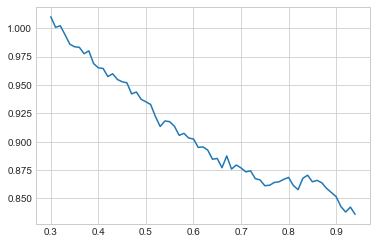

In [36]:
################TrainingCurve###############

error = []
stdev = []
t = np.arange(0.3, 0.95, 0.01) ## Size of training split: (start, stop, step_size)

for ts in t:
   
    sub_error = []
    for i in range(60,110): ## Indices over which you cross-validate. This is currently 50-fold cross validation

        x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size = 1-ts, random_state = i)

        clf.fit(x_train, y_train)
        y_predict_rfr = clf.predict((x_test))
        y_train_pred =clf.predict((x_train))

        RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_predict_rfr))
        sub_error.append(RMSE)

    
    e = np.mean(sub_error)
    s = np.std(sub_error)
    print(e, s, ts)
    error.append(e)
    stdev.append(s)



try:
    plt.plot(t, error)
    plt.show()
except:
    print(":(")